On our impulse vacation couple of years back, we booked our stay via AirBnB. 

Since it was last minute, we were looking for something that was available and cheap. To my surprise, there were a few options available and they had a wide range of asking prices. 

Since now I understand data science and have worked on a few projects, I went out looking for datasets from AirBnB in order to explore coming up with simple model to predict optimal rental prices. 

Recently, AirBnB has also open sourced it's data and it is available 
__[here](http://insideairbnb.com/get-the-data.html)__

So, I thought of using Austin's data for our analysis. 

In this notebook, we will go over the following steps:

- *Loading datasets* : We will simply read data
- *Data munging* : We will clean data by imputing missing values
- *Explore data* : We will plot some charts and visually explore data
- *Feature engg* : We will create newer features, convert categorical variables
- *Building simple regression models* : We will split our data, do cv and build models
- *Making predictions* : We will make predictions on the held out test set
- *Checking accuracy* : We will measure the accuracy of our predictions against actual values in test set

For accuracy, we will use simple median absolute error metric. We can also use mean absolute error. However, since median is considered to be a robust statistic over mean, I am using median absolute error in our example. 

Note: Some interesting papers on this topic that I found and have picked some inspiration are from:
a) __[Predicting listing price on AirBnB dataset](https://cseweb.ucsd.edu/classes/wi17/cse258-a/reports/a052.pdf)__

b) __[Price Recommendation on Vacation Rental Websites](http://www.public.asu.edu/~swang187/publications/Price_Recommendation.pdf)__

### Dataset

The dataset consists of following files:
- listings.csv 
- calendar.csv
- reviews.csv
- neighborhoods.csv

Since we want to start by building a simple mode, we will load each of only from listings.csv and will select keep certain columns from listings.csv that seem to be important. We will also explore any missing values and / or outliers in our dataset

### Load data

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import ensemble
from sklearn import linear_model as lm
from sklearn.grid_search import GridSearchCV
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split, cross_val_score
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from matplotlib import pyplot
from datetime import datetime as dt
import time
import math
import xgboost as xgb
import operator
pd.set_option("max_columns", None)

In [2]:
all_listings_df = pd.read_csv('../data/listings.csv')
#Since price is an object data type, we will convert it to int
all_listings_df['price'] = all_listings_df['price'].map(lambda p: int(p[1:-3].replace(",", "")))
listing_price = all_listings_df['price']

/Users/chaitra/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (88) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Data Munging

In [3]:
listings_df = all_listings_df[['host_since', 
                         'host_is_superhost', 
                         'host_has_profile_pic', 
                         'host_identity_verified', 
                         'neighbourhood_cleansed', 
                         'property_type', 
                         'room_type', 
                         'accommodates', 
                         'bathrooms', 
                         'bedrooms', 
                         'beds', 
                         'bed_type', 
                         'price',  
                         'maximum_nights', 
                         'availability_30', 
                         'number_of_reviews',
                         'review_scores_rating',  
                         'instant_bookable', 
                         'cancellation_policy', 
                         'require_guest_profile_picture',
                         'require_guest_phone_verification', 
                         'reviews_per_month']]
listings_df.head()

,host_since,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,maximum_nights,availability_30,number_of_reviews,review_scores_rating,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month
0,2012-06-20,f,t,f,78756,House,Entire home/apt,5,2.0,3.0,4.0,Real Bed,130,1125,0,3,100.0,f,strict,t,t,0.07
1,2012-07-06,f,t,f,78756,House,Entire home/apt,7,2.0,3.0,5.0,Real Bed,500,7,25,2,99.0,f,strict,t,t,0.04
2,2014-01-27,f,t,f,78756,Apartment,Entire home/apt,4,1.0,1.0,2.0,Real Bed,195,1125,6,7,100.0,f,moderate,f,f,0.56
3,2015-12-06,f,t,t,78756,House,Entire home/apt,12,3.0,4.0,5.0,Real Bed,300,1125,23,3,93.0,f,strict,f,f,0.25
4,2014-07-24,t,t,f,78756,House,Entire home/apt,2,1.0,1.0,1.0,Real Bed,105,1125,10,122,98.0,f,moderate,f,f,4.24


In [4]:
listings_df.shape

(9663, 22)

So, we have a small dataset of ~9k rows

In [5]:
#Let's check to see which columns have any missing values
listings_df.columns[listings_df.isnull().any()]

Index([u'host_since', u'host_is_superhost', u'host_has_profile_pic',
       u'host_identity_verified', u'bathrooms', u'bedrooms', u'beds',
       u'review_scores_rating', u'reviews_per_month'],
      dtype='object')

In [6]:
#Let's find the number of rows in each column that has nans
def count_nan_rows(df_column):
    return listings_df[df_column].isnull().sum()

nan_columns = [u'host_since', u'host_is_superhost', u'host_has_profile_pic',
       u'host_identity_verified', u'bathrooms', u'bedrooms', u'beds',
       u'review_scores_rating', u'reviews_per_month']

for df_col in nan_columns:
    num_nan_rows = count_nan_rows(df_col)
    print df_col, 'has', num_nan_rows, 'missing rows of data', '\n'

host_since has 2 missing rows of data 

host_is_superhost has 2 missing rows of data 

host_has_profile_pic has 2 missing rows of data 

host_identity_verified has 2 missing rows of data 

bathrooms has 41 missing rows of data 

bedrooms has 6 missing rows of data 

beds has 26 missing rows of data 

review_scores_rating has 3720 missing rows of data 

reviews_per_month has 3656 missing rows of data 



In [7]:
#Let's investigate the rows that have missing host_since
listings_df[listings_df.host_since.isnull()]

,host_since,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,maximum_nights,availability_30,number_of_reviews,review_scores_rating,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month
1369,NaN,NaN,NaN,NaN,78741,Apartment,Private room,1,1.0,1.0,1.0,Real Bed,26,5,0,4,93.0,f,flexible,f,f,0.22
6521,NaN,NaN,NaN,NaN,78704,Apartment,Entire home/apt,2,1.0,1.0,1.0,Airbed,75,1125,0,1,NaN,f,strict,f,f,0.05


So, it looks like the same two rows have missing host_since, host_is_superhost, host_has_profile_pic, host_identity_verified. After looking at these two rows, it seems like it may be safe to drop these rows since: 

- these are just two rows in ~9k rows of data and 
- they seem to have updated their calendar way back and have small reviews_per_month and 
- they have various other columns missing as well

In [8]:
listings_df = listings_df[~listings_df.host_since.isnull()]

In [9]:
#Next, let's investigate the rows with missing number of bedrooms and bathrooms
listings_df[listings_df.bathrooms.isnull()]

,host_since,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,maximum_nights,availability_30,number_of_reviews,review_scores_rating,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month
197,2013-03-08,f,t,f,78751,House,Private room,3,NaN,1.0,NaN,Real Bed,200,1125,30,0,NaN,f,flexible,f,f,NaN
209,2011-11-08,f,t,f,78751,House,Private room,6,NaN,1.0,NaN,Real Bed,400,21,30,0,NaN,f,flexible,f,f,NaN
607,2012-11-07,f,t,f,78732,House,Entire home/apt,8,NaN,4.0,NaN,Real Bed,1500,1125,30,0,NaN,f,flexible,f,f,NaN
1124,2013-03-01,f,t,f,78728,Apartment,Private room,2,NaN,1.0,NaN,Real Bed,110,1125,30,0,NaN,f,strict,f,f,NaN
1223,2012-10-06,t,t,t,78744,House,Entire home/apt,6,NaN,1.0,NaN,Real Bed,500,1125,30,0,NaN,f,flexible,f,f,NaN
1465,2012-11-15,f,t,f,78741,Apartment,Private room,2,NaN,1.0,NaN,Real Bed,125,1125,30,0,NaN,f,flexible,f,f,NaN
1498,2012-05-15,f,t,f,78741,House,Private room,1,NaN,1.0,1.0,Real Bed,88,1125,30,3,100.0,f,flexible,f,t,0.07
1499,2012-05-15,f,t,f,78741,House,Private room,2,NaN,1.0,1.0,Real Bed,60,1125,30,3,90.0,f,flexible,f,t,0.08
2014,2015-09-29,f,f,f,78722,Apartment,Shared room,1,NaN,1.0,NaN,Real Bed,200,1125,30,0,NaN,f,flexible,f,f,NaN
2147,2013-03-06,f,t,f,78722,House,Private room,2,NaN,1.0,NaN,Real Bed,200,1125,30,1,97.0,f,flexible,f,f,0.02


One way to fill in the missing number of bathrooms would be to take a look at the median number of bathrooms in the homes with same size (# of bedrooms and property_type)

In [10]:
listings_df.loc[listings_df.bathrooms.isnull(), 'bathrooms'] = listings_df.groupby(['property_type', 'bedrooms']).bathrooms.transform('median')

Next, we will move on to imputing missing values for number of bedrooms.

Sometimes, hosts rent a couch in the living room. In that case, the # of bedrooms is 0. With that in mind, we will impute missing # of bedrooms = 0 if the room_type is 'Private Room'. 

On the other hand, if the host is renting entire property, we will impute the missing values of bedrooms by looking up median number of bedrooms by property_type

We will first peek at the rows that have missing number of bedrooms. 

In [11]:
listings_df.loc[listings_df.bedrooms.isnull(), ['property_type', 'room_type']]

,property_type,room_type
1906,Apartment,Entire home/apt
5803,Apartment,Private room
7039,Apartment,Entire home/apt
7287,Apartment,Entire home/apt
7500,House,Entire home/apt
8260,House,Entire home/apt


In [12]:
listings_df.loc[(listings_df.bedrooms.isnull()) & (listings_df.room_type == 'Entire home/apt'), 'bedrooms'] = listings_df.groupby(['property_type']).bedrooms.transform('median')
listings_df.loc[(listings_df.bedrooms.isnull()) & (listings_df.room_type == 'Private room'), 'bedrooms'] = 0

Next, we will look at the missing values in number of beds. 

Imputing number of beds can be a bit tricky though. For example, host may fit in one king sized bed / two twin beds in a bedroom. Similarly, host may simply rent their couch in the living room / provide air-mattress or sleeping bag and enlist # of beds as greater than 0. 

Since we do not have enough information to impute the values correctly, we will simply replace missing beds with -1. That's one way to indicate our algorithm that values are missing and different than usual. 

In [13]:
listings_df['beds'].fillna(-1, inplace = True)

For review_score_rating and reviews_per_month, we will see how many total number of reviews the listing has. 

If it is 0, review_score_rating and reviews_per_month should be imputed to  0 because no ratings is a rating of 0 stars. 

On the other hand, when I checked random listing urls (add listing_url and read the data from listings.csv again) of the listings that had number of reviews > 0 and still missing review_score_rating and reviews_per_month, all of these reviews were automated postings like: 'The host canceled this reservation the day before arrival. This is an automated posting.' Hence, these values too should be imputed to 0. 

Based on this, we will simply fill any NaN's in review_score_rating and reviews_per_month with 0. 

Also, based on this investigation, one of the interesting features worth adding would be 'number of times cancel the reservation'. This would computed as follows:
if number of reviews > 0 and review_score_rating = NaN, 'number of times cancel the reservation' = number of reviews

else, 'number of times cancel the reservation' = 0

Hence, we will first create this new feature and then fill NaN's

In [14]:
#Find number of times host cancelled
listings_df['num_times_host_cancelled'] = 0
listings_df.loc[(listings_df.review_scores_rating.isnull()) & (listings_df.number_of_reviews > 0), 'num_times_host_cancelled'] = listings_df['number_of_reviews']

In [15]:
#Impute missing values for review_score_rating and reviews_per_month
listings_df[['review_scores_rating', 'reviews_per_month']] = listings_df[['review_scores_rating', 'reviews_per_month']].fillna(0)

In [16]:
#again, let's check if there any missing values in any of the columns
listings_df.columns[listings_df.isnull().any()]

Index([u'bathrooms'], dtype='object')

In [17]:
listings_df.loc[listings_df.bathrooms.isnull(), ['property_type', 'bedrooms', 'bathrooms']]

,property_type,bedrooms,bathrooms
8260,House,2.0,NaN


This is the last row missing that was not imputed as # of bedrooms was missing too in our original dataframe. Now that we have # of bedrooms inputed, we can use this information to impute # of bathrooms using the same mechanism as employed before

In [18]:
listings_df.loc[listings_df.bathrooms.isnull(), 'bathrooms'] = listings_df.groupby(['property_type', 'bedrooms']).bathrooms.transform('median')

### Explore Data

Now that we have our missing values filled out, we can plot some graphs and check to see if we find any interesting patterns. 

Since we have not explored 'neighborhood_cleansed' column yet, let's look at what that column looks like.

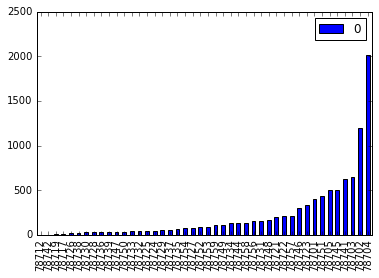

In [19]:
neigh_counts = Counter(listings_df.neighbourhood_cleansed)
neigh_char_data = pd.DataFrame.from_dict(neigh_counts, orient='index').sort_values(by=0)
neigh_char_data.plot(kind='bar')

This variable consists of neighborhoods split by the zip codes. Not all the neighborhoods are represented equally in our dataset. Most of the rental properties are concentrated in the zip codes of 78702 / 78704 that refer to the neighborhood near Austin Downtown. 

Next, since Austin is a big city, let's look at the distribution of rental prices

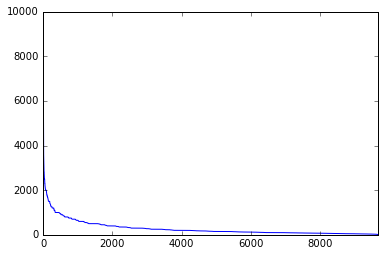

In [20]:
listings_df['price'].sort_values(ascending = False).reset_index(drop = True).plot()

Clearly, we have some outliers. However, most the rentals are in the range of high $1000s. Let's find out the distribution of rental price

In [21]:
listings_df.price.describe()

count     9661.000000
mean       292.838630
std        443.203476
min          0.000000
25%         89.000000
50%        160.000000
75%        340.000000
max      10000.000000
Name: price, dtype: float64

The above table shows that we have some outliers in our dataset. Let's examine what's the property that's most expensive in Austin

In [22]:
all_listings_df[all_listings_df.price == 10000]

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
2553,8306685,https://www.airbnb.com/rooms/8306685,20170306202425,2017-03-07,Austin Tarrytown F1 Weekend Estate,-Two miles from downtown Austin -6000 Square f...,NaN,-Two miles from downtown Austin -6000 Square f...,none,NaN,NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/105771939/...,https://a0.muscache.com/im/pictures/105771939/...,https://a0.muscache.com/im/pictures/105771939/...,https://a0.muscache.com/im/pictures/105771939/...,41628396,https://www.airbnb.com/users/show/41628396,James,2015-08-16,NaN,NaN,NaN,NaN,NaN,f,https://a0.muscache.com/im/users/41628396/prof...,https://a0.muscache.com/im/users/41628396/prof...,Old Enfield,1.0,1.0,['phone'],t,f,"Preston Avenue, Austin, TX 78703, United States",Old Enfield,78703,NaN,Austin,TX,78703.0,Austin,"Austin, TX",US,United States,30.295702,-97.753720,t,House,Entire home/apt,10,4.0,4.0,4.0,Real Bed,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",NaN,10000,NaN,NaN,NaN,NaN,1,$0.00,3,3,18 months ago,NaN,0,0,0,0,2017-03-06,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,strict,f,f,1,NaN
4910,11674090,https://www.airbnb.com/rooms/11674090,20170306202425,2017-03-07,one bedroom in 2 story house,private room and bath. located minutes to down...,NaN,private room and bath. located minutes to down...,none,NaN,NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/a184e6dd-e...,https://a0.muscache.com/im/pictures/a184e6dd-e...,https://a0.muscache.com/im/pictures/a184e6dd-e...,https://a0.muscache.com/im/pictures/a184e6dd-e...,61662430,https://www.airbnb.com/users/show/61662430,Beverly,2016-03-05,"Austin, Texas, United States",NaN,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/6e222d08-3...,https://a0.muscache.com/im/pictures/6e222d08-3...,NaN,2.0,2.0,"['email', 'phone', 'facebook']",t,f,"Strickland Drive, Austin, TX 78748, United States",NaN,78748,NaN,Austin,TX,78748.0,Austin,"Austin, TX",US,United States,30.181430,-97.815041,t,House,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",""Air conditio...",NaN,10000,NaN,NaN,NaN,NaN,1,$0.00,1,1125,12 months ago,NaN,30,60,90,365,2017-03-06,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,flexible,f,f,2,NaN
8638,4538217,https://www.airbnb.com/rooms/4538217,20170306202425,2017-03-07,The Cathédrale,"A spacious, fully-furnished, home with Parisia...",NaN,"A spacious, fully-furnished, home with Parisia...",none,NaN,NaN,Just off I-35 in the tree-lined Windsor Park n...,NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/74944003/a...,NaN,22773046,https://www.airbnb.com/users/show/22773046,Eli,2014-10-20,"Austin, Tex

The second seems like a spam / incorrect posting. Private room in Austin going for $10000?

Anyhow, for the next step, we will try to explore how some of the seemingly important features are related to price. However, in order to avoid extreme values skew our plot, we will restrict our plots to data where price <= $400 per night. 

The most important aspect of any real estate is location. So, we will first explore how the prices stack up across different neighborhoods

In [23]:
listings_df.columns

Index([u'host_since', u'host_is_superhost', u'host_has_profile_pic',
       u'host_identity_verified', u'neighbourhood_cleansed', u'property_type',
       u'room_type', u'accommodates', u'bathrooms', u'bedrooms', u'beds',
       u'bed_type', u'price', u'maximum_nights', u'availability_30',
       u'number_of_reviews', u'review_scores_rating', u'instant_bookable',
       u'cancellation_policy', u'require_guest_profile_picture',
       u'require_guest_phone_verification', u'reviews_per_month',
       u'num_times_host_cancelled'],
      dtype='object')

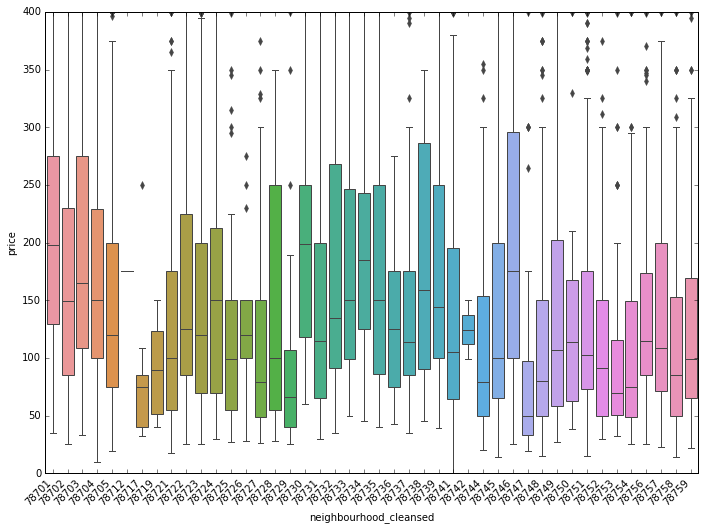

In [24]:
#set bigger plot area
a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)

#set x-axis labels rotated to righ at 45 deg angle
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

sns.boxplot(y = 'price', x = 'neighbourhood_cleansed',
            data = listings_df[listings_df.price <= 400])

As expected, neighboorhood seems to impact the average rental price effectively. The average rental prices are high around downtown areas (78701 / 78702 and so on) while it is ivery low in northwest austin area (78717 / 78719 for example). 

Property type seems like the another important feature. So, let's explore it's impact on price 

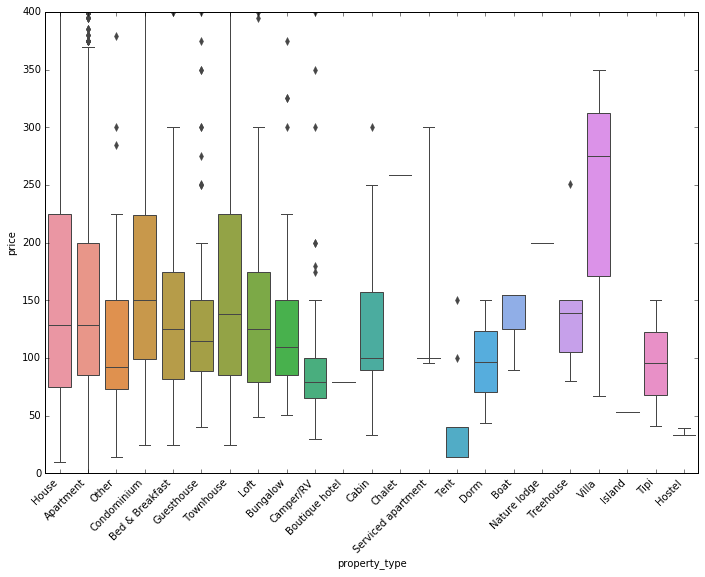

In [25]:
#set bigger plot area
a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)

#set x-axis labels rotated to righ at 45 deg angle
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
sns.boxplot(y = 'price', x = 'property_type',
            data = listings_df[listings_df.price <= 400])

Villa seems to be most expensive rentals followed by condos. Surprisingly, average rental price for condos is higher than that for house. 

One reason might be because condo rentals may have more 'Entire apt' rentals vs just 'Private rooms' which maybe more likely in case of houses. 

Speaking of room_type, we can also explore how the different room_types stack up

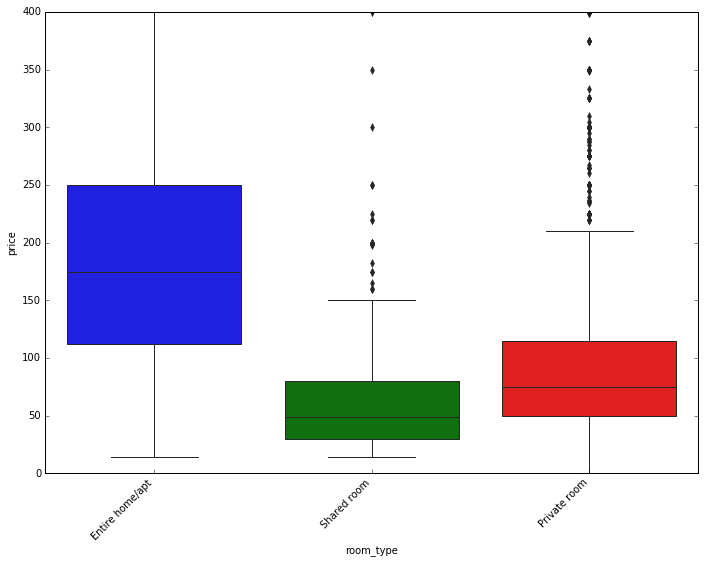

In [26]:
#set bigger plot area
a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)

#set x-axis labels rotated to righ at 45 deg angle
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
sns.boxplot(y = 'price', x = 'room_type',
            data = listings_df[listings_df.price <= 400])

As expected, entire home can demand more rent than shared room or private room. However, it's interesting to see that there is a small difference between average rental for shared and private room. While the average rental for entire home / apartment is much higher. 

Let's see if being instantly bookable has any impact on the price

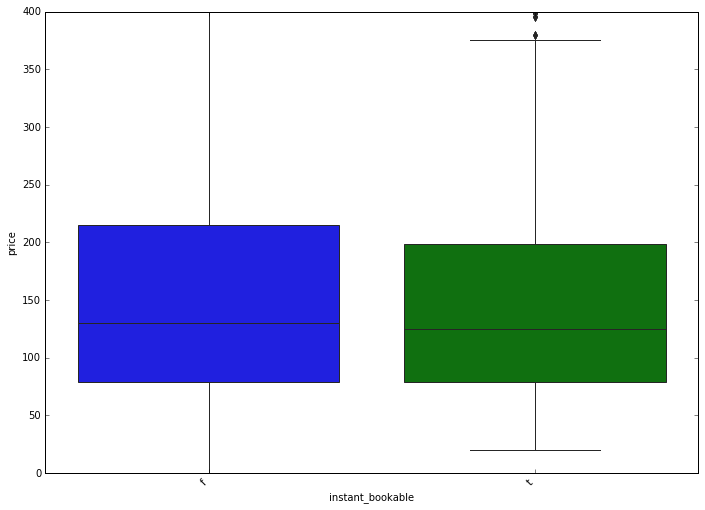

In [27]:
#set bigger plot area
a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)

#set x-axis labels rotated to righ at 45 deg angle
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
sns.boxplot(y = 'price', x = 'instant_bookable',
            data = listings_df[listings_df.price <= 400])

There doesn't seem to be much of difference in the average rental price if property can be instantly booked or not. 

Next, we will look at the impact of cancellation policy 

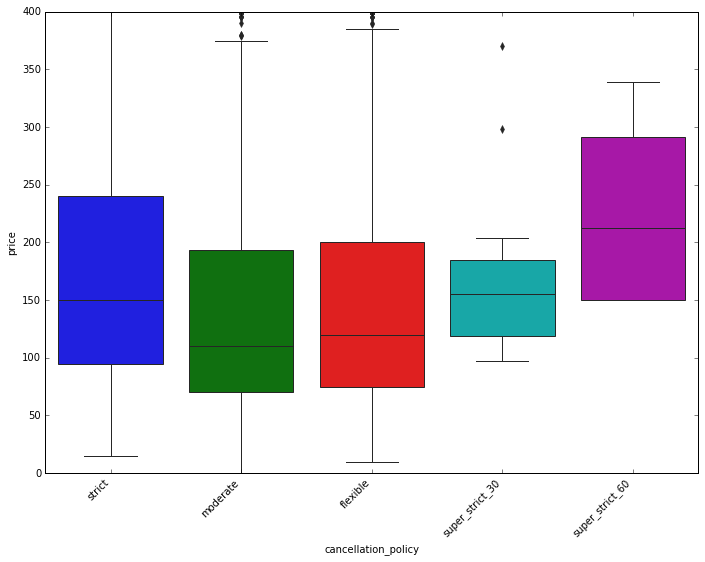

In [28]:
#set bigger plot area
a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)

#set x-axis labels rotated to righ at 45 deg angle
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
sns.boxplot(y = 'price', x = 'cancellation_policy',
            data = listings_df[listings_df.price <= 400])

Intrestingly, superstrict cancellation policy demand for more average nightly rental. 

If we also had booking data, it would interesting to see if there is any relation between # of bookings and different types of cancellation policy. 

Next, since we created a new feature on 'num_times_host_cancelled', let's see if that has any relation with price

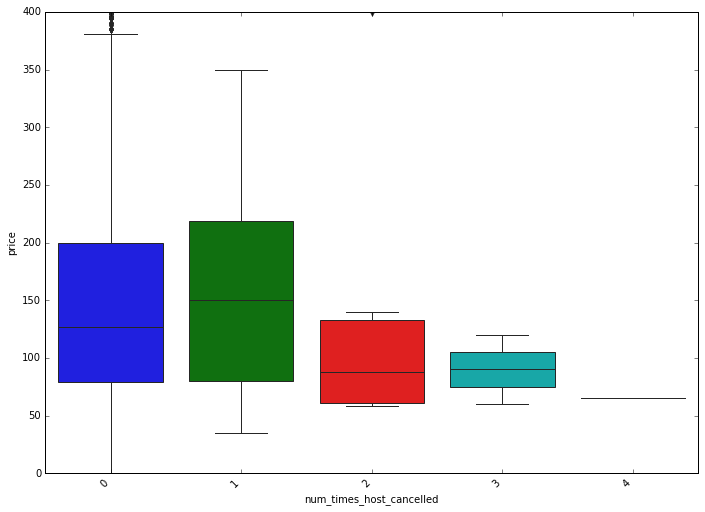

In [29]:
#set bigger plot area
a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)

#set x-axis labels rotated to righ at 45 deg angle
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
sns.boxplot(y = 'price', x = 'num_times_host_cancelled',
            data = listings_df[listings_df.price <= 400])



We see that there isn't much of a difference in the average rental price if the host has cancelled once. However, since the second cancellation, the average listing price is lower

Lastly, we will look at the impact of host_has_profile_pic feature on the average rental price

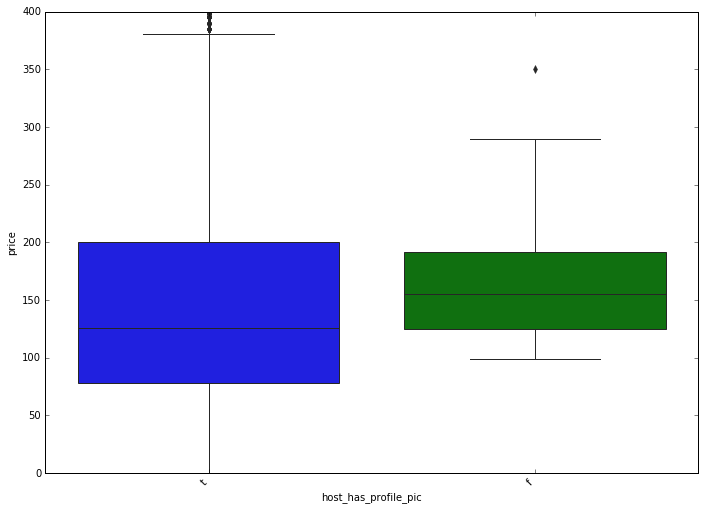

In [30]:
#set bigger plot area
a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)

#set x-axis labels rotated to righ at 45 deg angle
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
sns.boxplot(y = 'price', x = 'host_has_profile_pic',
            data = listings_df[listings_df.price <= 400])


Apparently, having a profile pic also matters. 

Finally, we will look at pair plots to visualize if there is any correlation between any of the predicotr variables. 

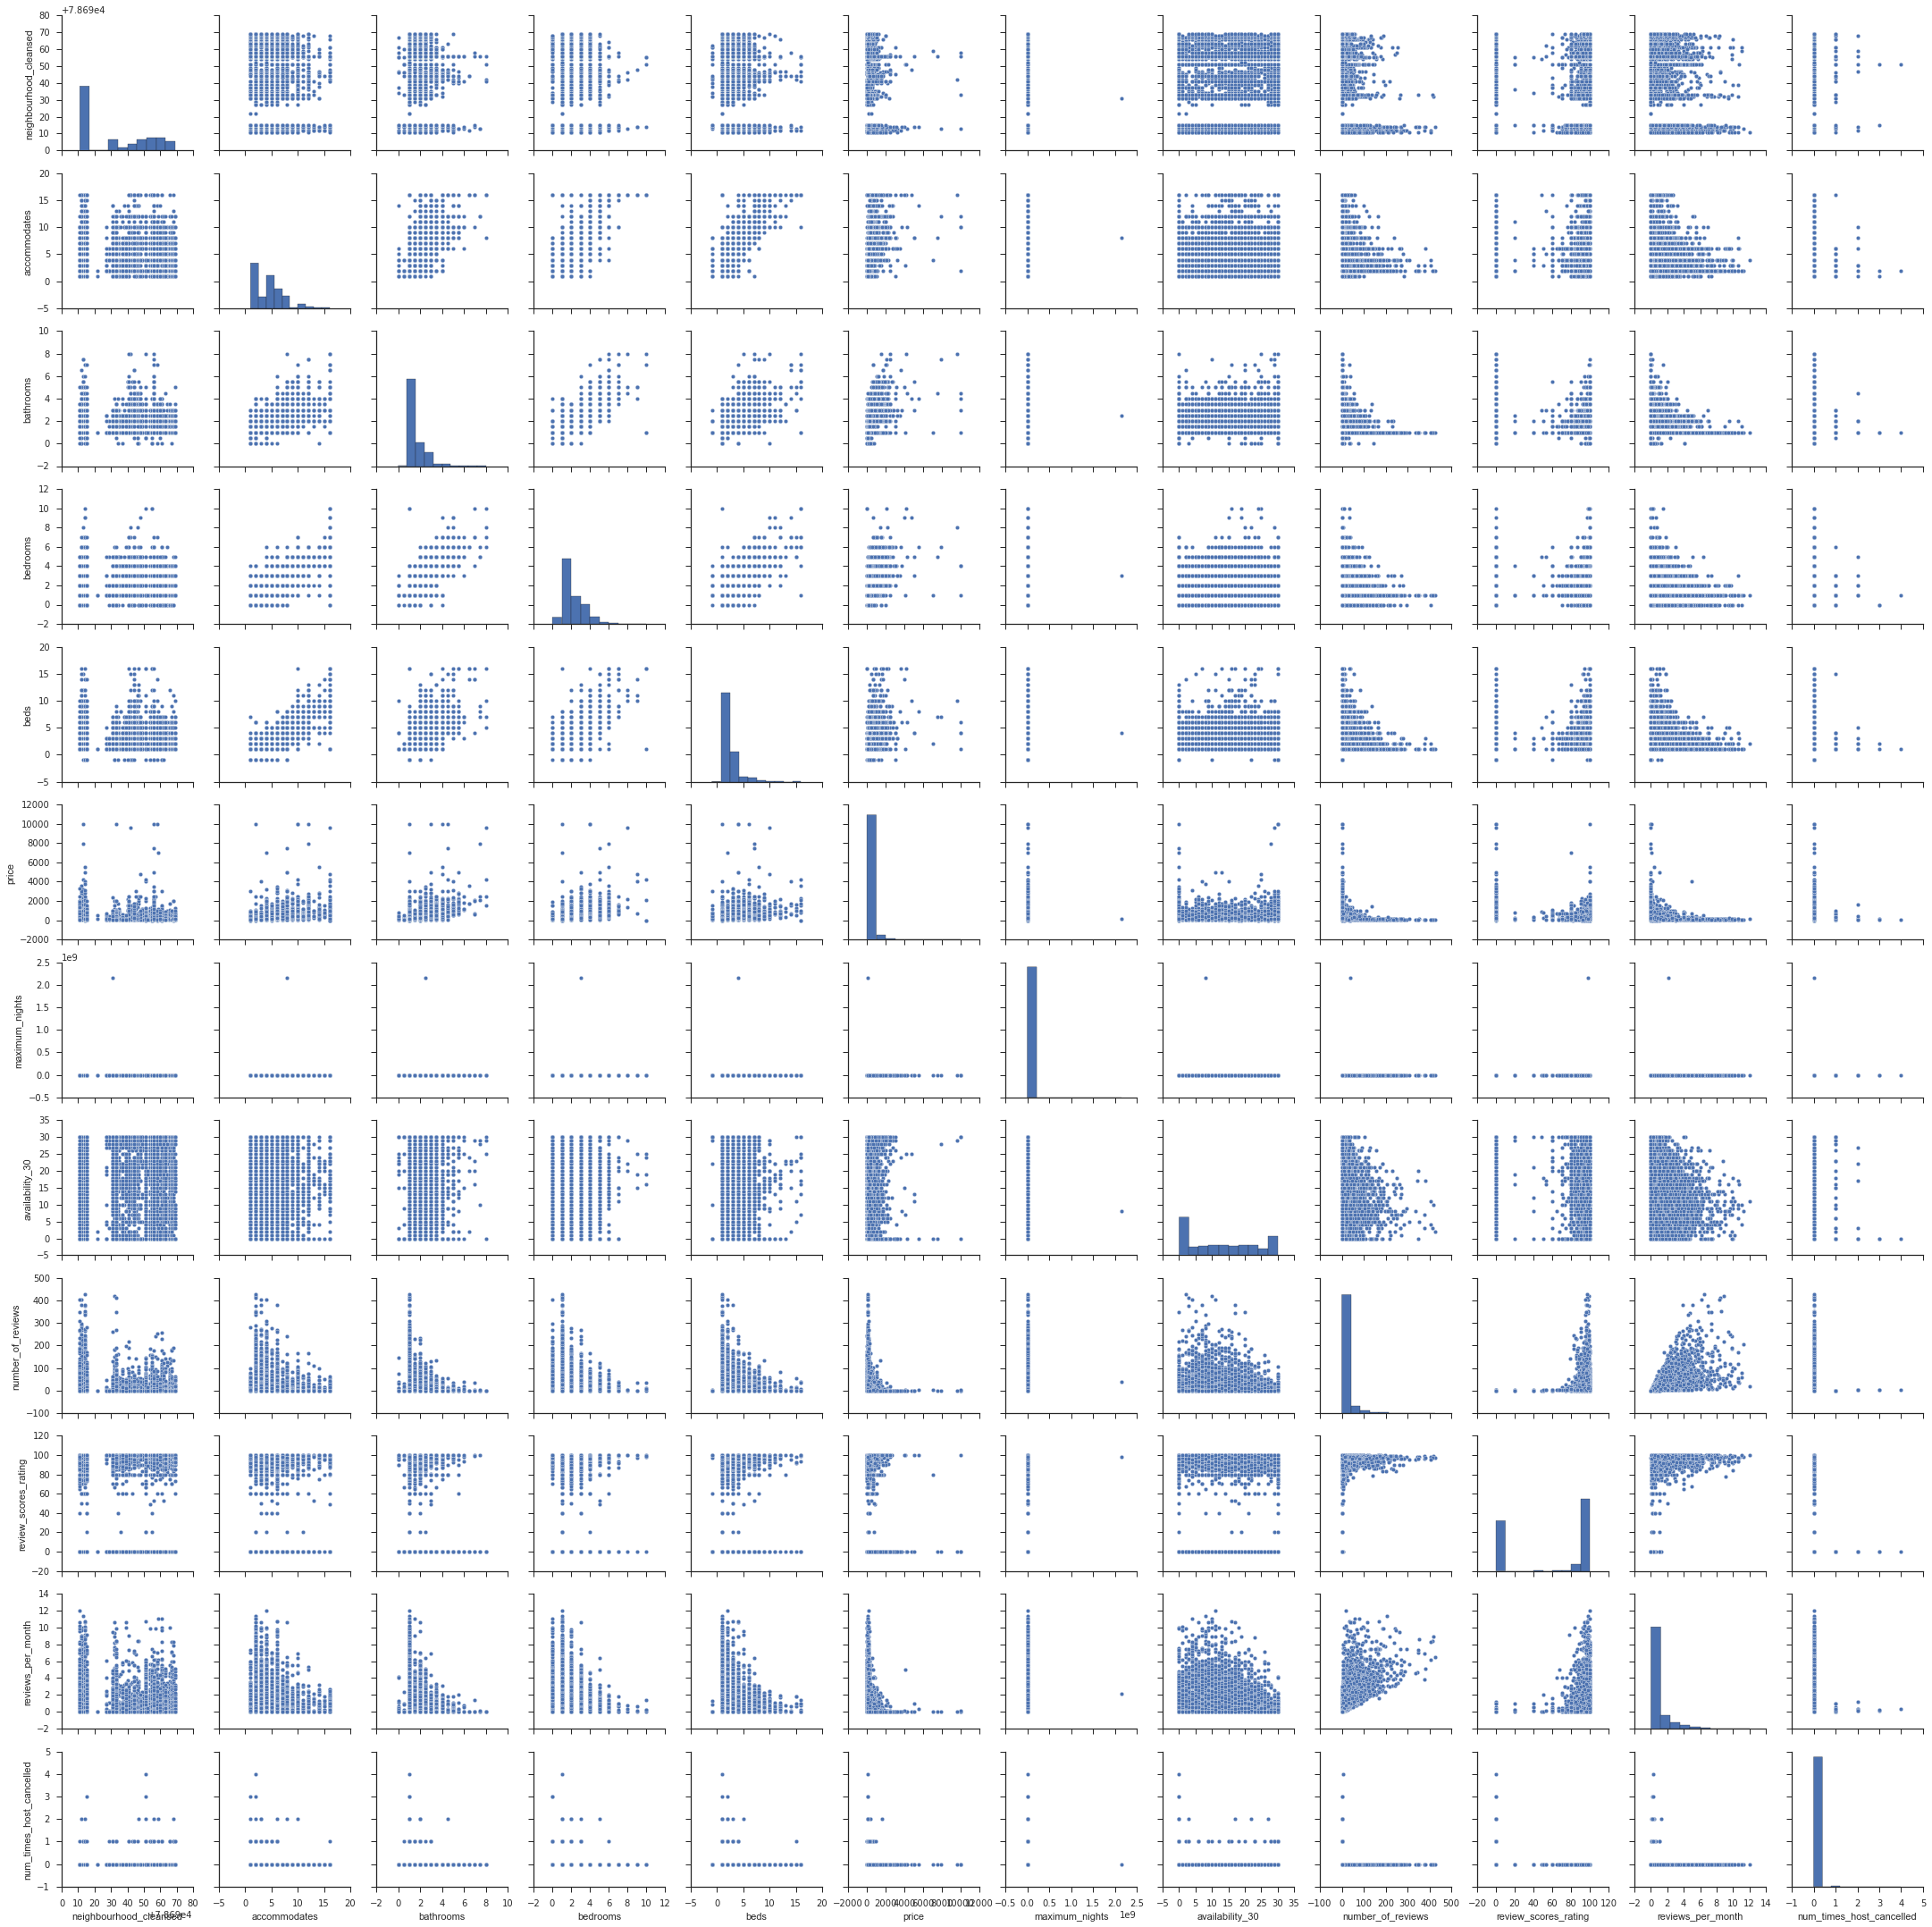

In [31]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(listings_df)

There is some weak relation between # of bedrooms and bathrooms and that's expected. There is also some weak relation between # of beds and accomodates and that is expected too. However, in the both the cases, the relation is not strong. 

Apart from those, no feature shows any obvious colinearity. 

### Feature Engineering

Since we are building simple regression model, we will convert all the categorical variables into one-hot encoded variables / dummy variables. 

One-hot encoding is a simple idea wherein we convert every categorical variable in our dataset to numerical variable with 0s and 1s. Ex: In our dataset, we have categorical variable host_is_superhost with two possible outcomes - t / f. When we one-hot encode them, we will create two columns: host_is_superhost_true / host_is_superhost_false. 

Technically, we can get away with using just one column as a host can only either BE a superhost or NOT. And that's the mechanism we will use in our data

In [32]:
listings_df.head()

,host_since,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,maximum_nights,availability_30,number_of_reviews,review_scores_rating,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month,num_times_host_cancelled
0,2012-06-20,f,t,f,78756,House,Entire home/apt,5,2.0,3.0,4.0,Real Bed,130,1125,0,3,100.0,f,strict,t,t,0.07,0
1,2012-07-06,f,t,f,78756,House,Entire home/apt,7,2.0,3.0,5.0,Real Bed,500,7,25,2,99.0,f,strict,t,t,0.04,0
2,2014-01-27,f,t,f,78756,Apartment,Entire home/apt,4,1.0,1.0,2.0,Real Bed,195,1125,6,7,100.0,f,moderate,f,f,0.56,0
3,2015-12-06,f,t,t,78756,House,Entire home/apt,12,3.0,4.0,5.0,Real Bed,300,1125,23,3,93.0,f,strict,f,f,0.25,0
4,2014-07-24,t,t,f,78756,House,Entire home/apt,2,1.0,1.0,1.0,Real Bed,105,1125,10,122,98.0,f,moderate,f,f,4.24,0


In [33]:
listings_data = pd.get_dummies(data = listings_df, 
                            prefix = ['host_is_superhost', 
                                      'host_has_profile_pic', 
                                      'host_identity_verified', 
                                      'neighbourhood_cleansed', 
                                      'property_type',
                                      'room_type', 
                                      'bed_type', 
                                      'instant_bookable', 
                                      'cancellation_policy', 
                                      'require_guest_profile_picture', 
                                      'require_guest_phone_verification'], 
                            columns = ['host_is_superhost', 
                                      'host_has_profile_pic', 
                                      'host_identity_verified', 
                                      'neighbourhood_cleansed', 
                                      'property_type',
                                      'room_type', 
                                      'bed_type', 
                                      'instant_bookable', 
                                      'cancellation_policy', 
                                      'require_guest_profile_picture', 
                                      'require_guest_phone_verification'], 
                           drop_first = True)

Since we have date since host has assumed their role, we can find for how long they have been a host. 

The dataset we have was last updated in March 2017. When we look for max() date in hosted_since column, we see it is March 06th. So, we will find for how long host has been a host as of March 06th

In [34]:
listings_data['host_since'] = pd.to_datetime(listings_data['host_since'])
listings_data['num_days_since_host'] = dt.strptime('2017-03-06', '%Y-%m-%d') - listings_data['host_since']
listings_data['num_days_since_host'] = listings_data['num_days_since_host'].dt.days

Let's now look at the distribution of num_days_since_host

In [35]:
listings_data['num_days_since_host'].describe()

count    9661.000000
mean     1045.272332
std       632.657633
min         0.000000
25%       535.000000
50%       977.000000
75%      1513.000000
max      3290.000000
Name: num_days_since_host, dtype: float64

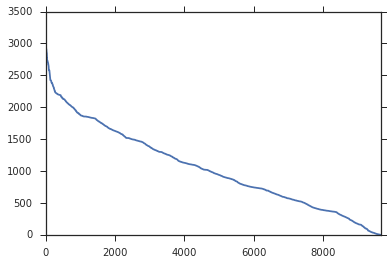

In [36]:
listings_data['num_days_since_host'].sort_values(ascending = False).reset_index(drop = True).plot()

From the graph and the distribution, looks like we have a few outliers (values that are more than 3 std away from mean). 

We will look at the distribution of all the numerical variables

In [37]:
listings_data[['accommodates', 
               'bathrooms', 
               'bedrooms', 
               'beds', 
               'maximum_nights', 
               'availability_30', 
               'number_of_reviews', 
               'review_scores_rating', 
               'reviews_per_month', 
               'num_times_host_cancelled']].describe()

,accommodates,bathrooms,bedrooms,beds,maximum_nights,availability_30,number_of_reviews,review_scores_rating,reviews_per_month,num_times_host_cancelled
count,9661.000000,9661.000000,9661.000000,9661.000000,9.661000e+03,9661.000000,9661.000000,9661.000000,9661.000000,9661.000000
mean,4.393541,1.509005,1.746921,2.249664,2.230019e+05,12.354829,13.919677,58.952179,0.845069,0.007970
std,2.718462,0.810082,1.164352,1.705970,2.184835e+07,10.611850,33.277277,46.923547,1.476680,0.108817
min,1.000000,0.000000,0.000000,-1.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,1.000000,1.000000,2.900000e+01,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,1.000000,1.000000,2.000000,1.125000e+03,11.000000,2.000000,93.000000,0.180000,0.000000
75%,6.000000,2.000000,2.000000,3.000000,1.125000e+03,21.000000,12.000000,99.000000,1.000000,0.000000
max,16.000000,8.000000,10.000000,16.000000,2.147484e+09,30.000000,427.000000,100.000000,12.000000,4.000000


The other requirement for regression is that all of the numerical variables should be on a similar scale. 

Based on the table above, there is a huge variation in maximum_nights column and it is also on a different scale as compared to other columns. 

Hence, we will 'normalize' maximum_nights column. Similarly, number_of_reviews column may need to be normalized as it has some wide range as well

In [38]:
listings_data['maximum_nights'] = (listings_data['maximum_nights'] - listings_data['maximum_nights'].min()) / (listings_data['maximum_nights'].max() - listings_data['maximum_nights'].min())
listings_data['number_of_reviews'] = (listings_data['number_of_reviews'] - listings_data['number_of_reviews'].min()) / (listings_data['number_of_reviews'].max() - listings_data['number_of_reviews'].min())

### Building simple regression models

We will use various linear regression models and plot the accuracy score for each of them. We will use regular linear regression,  ridge and lasso regressions and ElasticNet. 

Finally, we will also use everyone's favorite, xgboost and see if it gives us better accuracy. 

For accuracy, we will use median absolute error metric as discussed before. 

In [39]:
#We will start with forming our X and y
X = listings_data.drop(['price', 'host_since'], axis = 1).copy()
y = listings_data['price']

In [40]:
#Next, we will form a list of our estimators
estimators = [lm.LinearRegression(), 
              lm.Ridge(), 
              lm.Lasso(), 
              lm.ElasticNet()]
est_names = ['Linear', 'Ridge', 'Lasso', 'ElasticNet']
residuals = np.array([])

In [41]:
#We will now split our data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 23)

In [42]:
#Finally, we will find crossvalidated scores for each of our estimators
for est, est_name in zip(estimators, est_names):
    print 'Currently evaluating', est_name, 'model'
    start = time.time()
    for score in ['r2', 'median_absolute_error']:
        cur_cv_score = cross_val_score(est, X_train, y_train, scoring = score, cv = 5).mean()
        cur_cv_score = abs(cur_cv_score)
        residuals = np.append(residuals, cur_cv_score)
        print score, ':', cur_cv_score
    end = time.time()
    print 'Time elapsed = ', end - start, '\n'

Currently evaluating Linear model
r2 : 962474.307861
median_absolute_error : 98.7856388251
Time elapsed =  0.265717029572 

Currently evaluating Ridge model
r2 : 0.383013101359
median_absolute_error : 97.2434394839
Time elapsed =  0.125916004181 

Currently evaluating Lasso model
r2 : 0.373791974255
median_absolute_error : 93.2228312256
Time elapsed =  0.299257040024 

Currently evaluating ElasticNet model
r2 : 0.334257443684
median_absolute_error : 97.5004181932
Time elapsed =  0.251395940781 



Based on the results above, we see that a simple linear regression model performed worse than a model that just used average of all the prices. 

Best performance so far has been by ridge regression model which explains around 38% of variation in our data. The median absolute error is around $97. 

We will execute LinearRegressor model on the entire X_train and make predictions on X_test and measure the final accuracy score. 


In [43]:
final_lm = lm.LinearRegression()
final_lm.fit(X_train, y_train)
lm_predictions = final_lm.predict(X_test)
print metrics.median_absolute_error(y_test, lm_predictions)

99.3206763478


Considering that our median listing price is USD159 and average listing price is USD291, being off by ~USD100 is being off by more than 50%. 

Next, we will try some ensemble model such as xgboost and see how they stack up

In [44]:
# cv_params = {'learning_rate' : [0.1, 0.3, 0.5, 0.8], #shrinkage param
#              'min_child_weight' : [1, 5, 10], #min number of observations in each node
#             'subsample': [0.3, 0.5, 0.8], #% of training set that should be used for training
#             'colsample_bytree': [0.3, 0.5, 0.8], #% of columns that should be used for training
#             'max_depth': [3,5,7] #max depth of each tree
#             }

# ind_params = {'n_estimators': 1000, 'seed':0, 'objective': 'reg:linear'}

# optimized_XGBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
#                             cv_params, 
#                             scoring = 'median_absolute_error', 
#                             cv = 5, 
#                             n_jobs = -1 #use all cpus available
#                             ) 
# optimized_XGBM.fit(X_train, y_train)
# optimized_XGBM.grid_scores_

As with linear regression, we will fit the optimized regression model to complete X_train and predict optimal rental prices for data points in X_test. 

In [46]:
final_params = {'learning_rate': 0.1, 
               'min_child_weight': 10, 
               'subsample' : 0.8, 
               'colsample_bytree' : 0.5, 
               'max_depth' : 6}

xgdmat_train = xgb.DMatrix(X_train, y_train) # Create our DMatrix to make XGBoost more efficient

final_xgb_model = xgb.train(final_params, xgdmat_train, num_boost_round = 432)

In [49]:
xgdmat_test = xgb.DMatrix(X_test)
predictions = final_xgb_model.predict(xgdmat_test)
print metrics.median_absolute_error(y_test, predictions)

61.9089660645


The result of this attempt is a median absolute error of USD 62 

That seems far better than Ridge regression results. Our accuracy has gone up by ~40% already. 

Since xgboost also provides feature importance, let's conclude by looking at the important features. However, before that, 

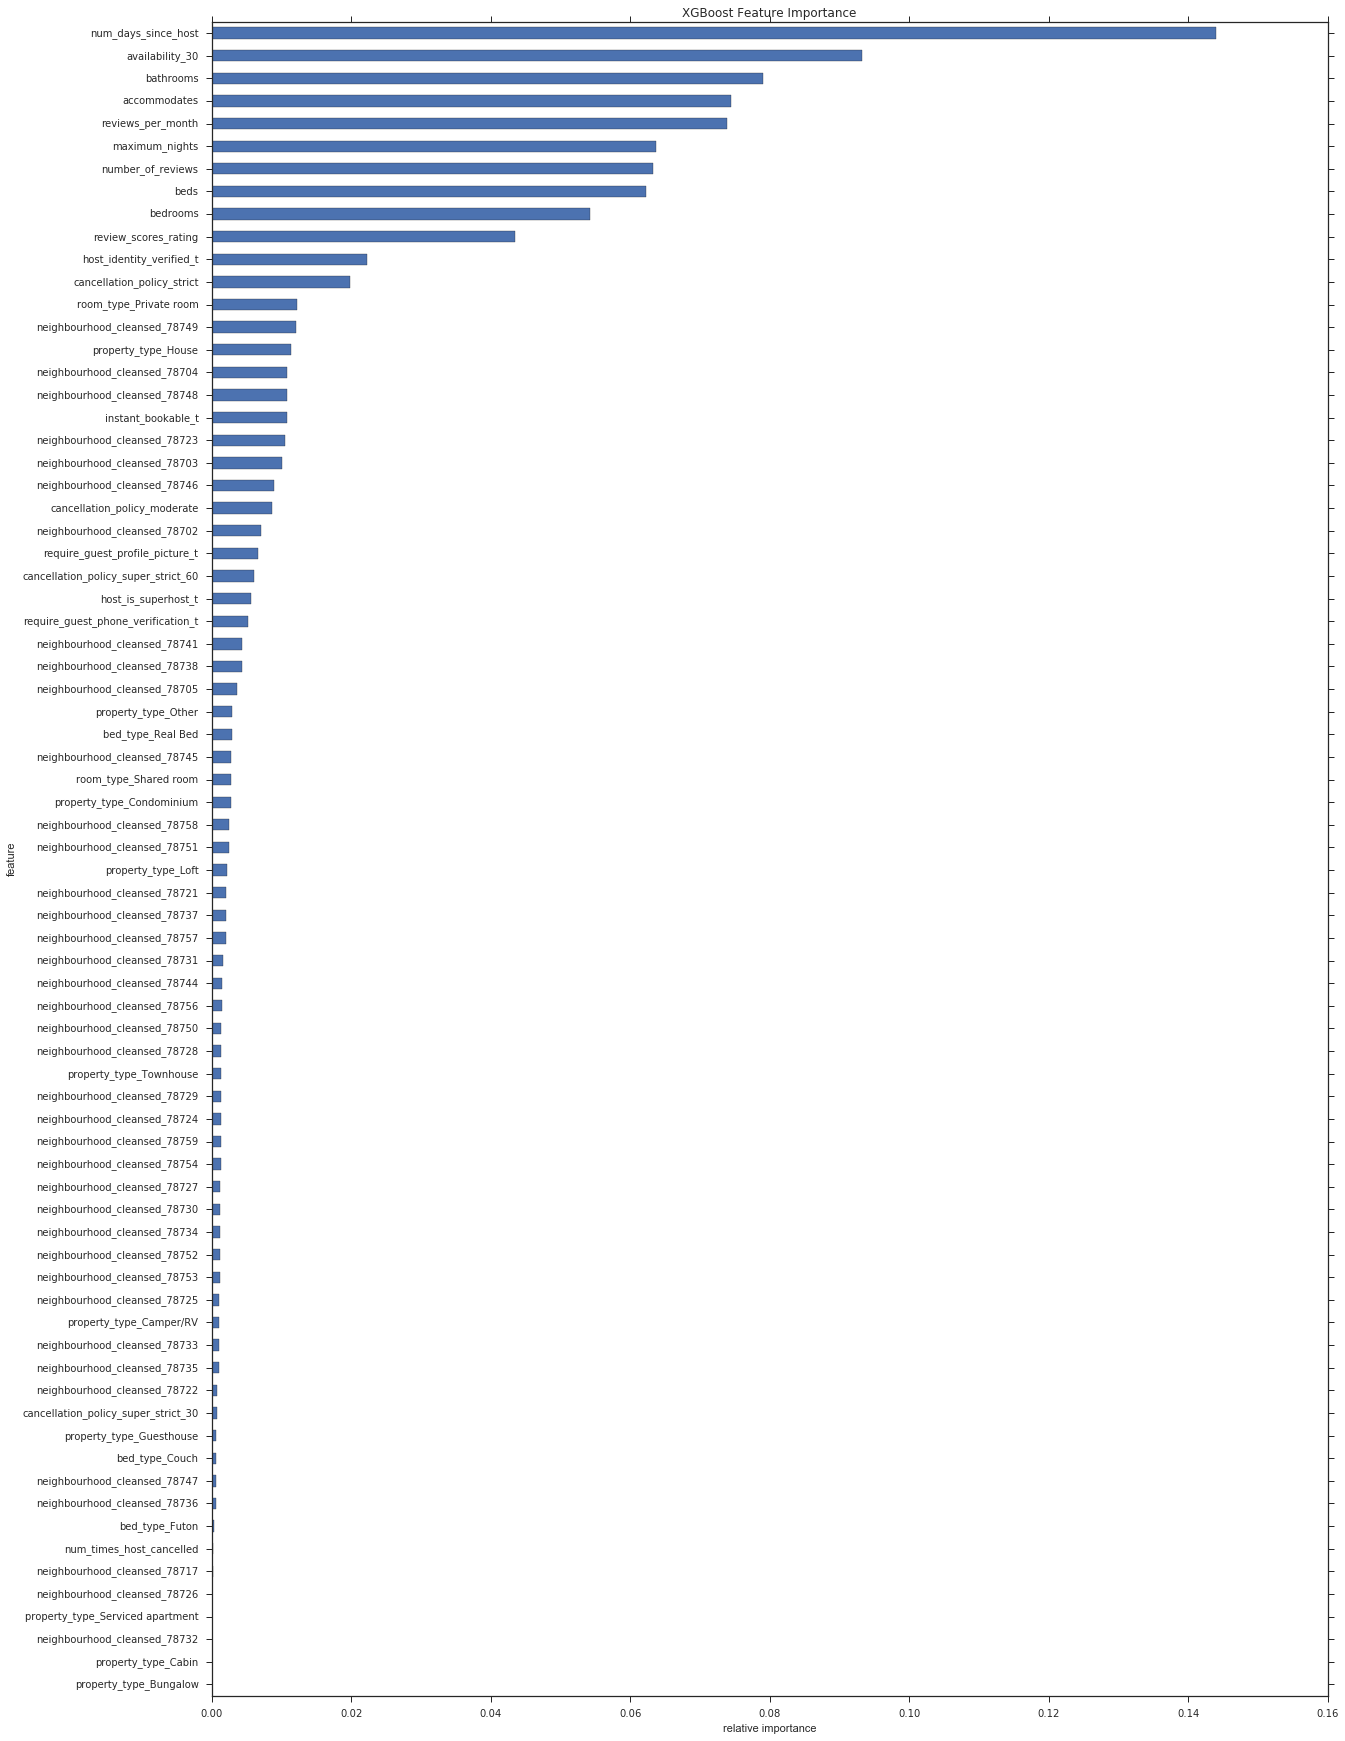

In [48]:
importance = final_xgb_model.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

plt.figure()
df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(20, 30))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.gcf().savefig('feature_importance_xgb.png')

### Next steps

For our current analysis, we explored only subset of data from listing.csv and used simple linear regression models followed by one ensemble model like Gradient Bossting. 

There are many ways in which our first-pass model can be improved. 
- We can include more data from listings
- We can add data from other data files for our analysis
- Use clustering algorithm to cluster our data points and possibly run different models on each cluster

Apart from predicting optimal rental price, we can extend to do topic modeling and / or sentiment analysis on review data. 